# Part 2: Deep Q Networks

**Before doing this, be sure you review the `README.md` file from the homework!**

**HUGE NOTE**: the third deliverable asks you to run Pong for several thousand steps.
Please start early, as the evaluation portion of this assignment can take many hours.
We provide some timing benchmarks for machines in the third deliverable.

In this part of the assignment, you will implement the Deep Q-Network algorithm
(DQN) [1], along with the Double DQN extension [2]. At a high level, the `dqn.py`
code builds a TensorFlow computational graph in the class initialization method.
Then, to train, it iterates through environment steps and model updates.

## Review

Recall from lecture that the DQN algorithm performs the following optimization:

\begin{equation}\label{eq:dqn}
{\rm minimize}_{\theta} \;\; \mathbb{E}_{(s_t,a_t,r_t,s_{t+1})\sim D}
\left[ 
\Big(r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a) - Q_\theta(s_t,a_t)\Big)^2
\right]
\end{equation}

Here, $(s_t,a_t,r_t,s_{t+1})$ are batches of samples from the experience replay
buffer $D$, which is designed to store the past $N$ samples (where usually
$N=1,000,000$ for Atari benchmarks) so as to break correlation among the
training data used for updating $\theta$. In addition, we use $\theta$ to
represent the *current* or *online* network, whereas $\theta^-$
represents the *target* network. Both networks use the same architecture,
and we use $Q_\theta(s,a)$ or $Q_{\theta^-}(s,a)$ to denote which of the two
parameters is being applied to evaluate the state-action tuple $(s,a)$.

The target network starts off by getting matched to the current network, but
remains frozen (usually for thousands of steps) before getting updated again to
match the network. The process repeats throughout training, with the goal of
increasing the stability of the targets $r_t + \gamma \max_{a \in \mathcal{A}}
Q_{\theta^-}(s_{t+1},a)$. For more details, we recommend reading [1].

In *Double* DQN, the target value changes slightly. The new optimization
problem is:

\begin{equation}\label{eq:ddqn}
{\rm minimize}_{\theta} \;\; \mathbb{E}_{(s_t,a_t,r_t,s_{t+1})\sim D}
\left[ 
\Big(r_t + \gamma Q_{\theta^-} \Big( s_{t+1}, {\rm argmax}_{a\in \mathcal{A}} Q_\theta(s_{t+1},a) \Big)  - Q_\theta(s_t,a_t)\Big)^2
\right]
\end{equation}

Notice the key difference in the target terms, which we denote $Y_t^{\rm DQN}$
and $Y_t^{\rm DoubleDQN}$ following the notation in [2]. Explicitly, we
have

\begin{equation}\label{eq:dqn_targ}
Y_t^{\rm DQN} = r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a)
\end{equation}

in DQN, and

\begin{equation}\label{eq:ddqn_targ}
Y_t^{\rm DoubleDQN} = r_t + \gamma
Q_{\theta^-} \Big( s_{t+1}, {\rm argmax}_{a\in \mathcal{A}} Q_\theta(s_{t+1},a) \Big)
\end{equation}

in DDQN. Intuitively, DDQN helps to mitigate the issue of over-optimistic values
from DQN. In DQN, for a given state $s$, the Q-network takes the maximum over
quantities $Q_{\theta^-}(s,a_k)$ for all actions $a_k \in \mathcal{A}$. In DDQN,
we consider the same $Q_{\theta^-}(s,a_k)$ values, yet are not guaranteed to
take the maximum one because the action selection is done by a different
network.  For more details, we recommend reading [2]. The paper also
covers the Double Q-Learning algorithm, which was originally developed in the
tabular settings.  The Double *Deep Q-Network* algorithm, which you will
also implement, is the minimal extension of DQN towards Double Q-Learning.

[1]: [DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf), read the Nature 2015 paper, not the NIPS 2013 workshop paper

[2]: [DDQN](https://arxiv.org/abs/1509.06461) at AAAI, 2016.


# DQN and DDQN Implementation (look at `dqn.py`)


**You will need to write code in `dqn.py` file in three specific spots.
These are clearly indicated with the comments `START OF YOUR CODE` and
`END OF YOUR CODE`.** Put your code between those comments. Concretely, they correspond to:

- Computing the Bellman Error.
- Environment Stepping
- Training

**See the comments in `dqn.py`, which provide detailed instructions. You
should not need to modify any other files for this part of the assigment**,
but you should browse through `dqn_utils.py`
to understand how supporting code (such as the replay buffer) is implemented,
and `train_dqn.py` to understand the command line arguments and algorithm
hyperparameters. *Look at the three "deliverable" cells 
later for the commands you can use on your command line to test your code*.

Some advice: implementing DQN can be tricky, and it is sometimes difficult to know if your
algorithm is working immediately due to the many samples necessary for deep
reinforcement learning. Thus, here is some advice:

- For implementing the computational graph, print out the tensors that you
form and check that the shapes make sense. When printed, the shape of the
leading dimension for certain tensors might be `?`, which represents a
"flexible" batch size: it either corresponds to the training batch size
hyperparameter, or just one.

- Do not engage in (extensive) hyperparmeter tuning. We provide
hyperparameters for you in `train_dqn.py` for both CartPole and Pong that
have empirically worked for our solutions. If you have the time, you may find it
helpful to tune the learning rate for CartPole.

- Run with CartPole as a sanity check before testing with Pong. If you're
getting at least 100 points on CartPole, that's a good sign. DQN, has high
variance, so run several random seeds.

- Once DQN is implemented, the addition of DDQN should only require on the
order of 2-4 additional lines of code, excluding `if/else` branches to account
for `args.double_q`.

For reference our DQN solution on PongNoFrameskip-v4 gets results in the following
figure, where we ran for five random seeds.

<img src="files/pong.png" width="500">

Each of the above curves was generated by running:

```
python train_dqn.py PongNoFrameskip-v4 --num_steps 4000000
```

which trains Pong for 4 million steps. The *plot* itself was generated by the same plotting code that you will use later on in this assignment (see "Deliverable" cells).


# Other Considerations (Code, Plotting, Logging, etc.)

As in the first part on policy gradients, you should test your code by running commands on your command line (rather than by running Jupyter notebook cells). The plotting, though, will still be done here for reporting purposes. See the three deliverables later for what you should be plotting, and the commands for doing so. Make sure that you don't change the cells, as the graders need consistency in seeing the results.

When you run the DQN, your log directory by default should be `data_dqn`, and its structure might look like this, where the date will vary based on when you ran the code:

```
data_dqn/
    dqn_PongNoFrameskip-v4_20-01-2019_11-58-27/
        log.txt
    dqn_PongNoFrameskip-v4_20-01-2019_12-00-04/
        log.txt
```

Each of the sub-files contains the algorithm used, the environment, and the date when the trial was launched.
The 'log.txt' files store the statistics from training, and are needed for the plots.

Load the following cell, which will get the plotting and other supporting code set up.


In [1]:
%load_ext autoreload
%autoreload 2

# Ensure your Python version makes sense
import sys
sys.version

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pandas as pd
import json, os


def plot(logdir, env, double_q, trials):
    fig = plt.figure(figsize=(9,7))

    for path in trials:
        full_path = os.path.join(logdir, path)
        log_path = os.path.join(full_path,'log.txt')
        name = path.replace('NoFrameskip-v4','')
        #data = pd.read_table(log_path)  # Daniel: this got deprecated
        data = pd.read_csv(log_path, sep='\t')  # in favor of this
        steps_million = data['Steps'] / 1e6
        plt.plot(steps_million, data['Avg_Last_100_Episodes'], lw=2, label=name)

    # Bells and whistles
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(loc='best', fontsize=20)
    plt.xlabel('Training Steps (in Millions)', fontsize=20)
    plt.ylabel('Avg Last 100 Episodes', fontsize=20)
    if double_q:
        plt.title('{} Double DQN'.format(env), fontsize=24)
    else:
        plt.title('{} DQN'.format(env), fontsize=24)
    plt.tight_layout()
    plt.show()

# Deliverable 1 of 3: DQN on CartPole-v0

On your command line, run:

```
python train_dqn.py CartPole-v0 --num_steps 100000
```

*Do this five times*.

Save the strings (starting with `'dqn_CartPole-v0_`) and put them in the `trials` list for plotting. Thus your data directory might look like this (with the dates obviously different):

```
data_dqn/
    dqn_CartPole-v0_01-04-2019_14-39-27
    dqn_CartPole-v0_01-04-2019_15-04-41
    dqn_CartPole-v0_01-04-2019_15-06-31
    dqn_CartPole-v0_01-04-2019_15-08-40
    dqn_CartPole-v0_01-04-2019_15-10-05
```

**Adjust the `trials` list below with your data directory names**. Run the following plotting code and save the output for your homework submission.

You should expect to see performance near 200 points for most of the curves, though DQN can be brittle on Pong and often performance will decline unexpectedly. One possibility might be to reduce the learning rate after a certain amount of steps. Feel free to try this out at the end of this assignemnt. See the last cell.

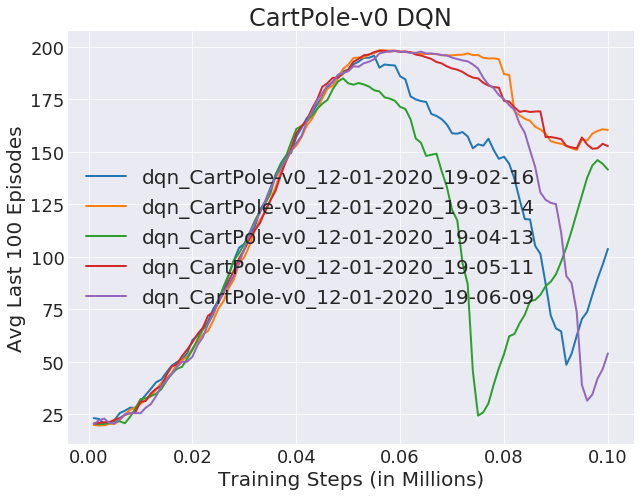

In [7]:
# Put a list of your DQN with CartPole trials here. Here's an example where I've put in
# my own trials, but you'll need to put in yours. The `trials` list should be length 5.

trials = [
    'dqn_CartPole-v0_12-01-2020_19-02-16',
    'dqn_CartPole-v0_12-01-2020_19-03-14',
    'dqn_CartPole-v0_12-01-2020_19-04-13',
    'dqn_CartPole-v0_12-01-2020_19-05-11',
    'dqn_CartPole-v0_12-01-2020_19-06-09',
]

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
if len(trials) != 5:
    print("WARNING! len(trials) = {}".format(len(trials)))
    print("Please include 5 results for your final report.")
for t in trials:
    assert t[:4] == 'dqn_'
    assert t[:7] != 'double-'
    assert 'CartPole-v0' in t
    assert 'Pong' not in t
plot(logdir='data_dqn', env='CartPole-v0', double_q=False, trials=trials)

# Deliverable 2 of 3: DDQN on CartPole-v0

On your command line, run:

```
python train_dqn.py CartPole-v0 --num_steps 100000  --double_q
```

For *five* times.

**Adjust the `trials` list below with your data directory names**. Run the following plotting code and save the output for your homework submission.

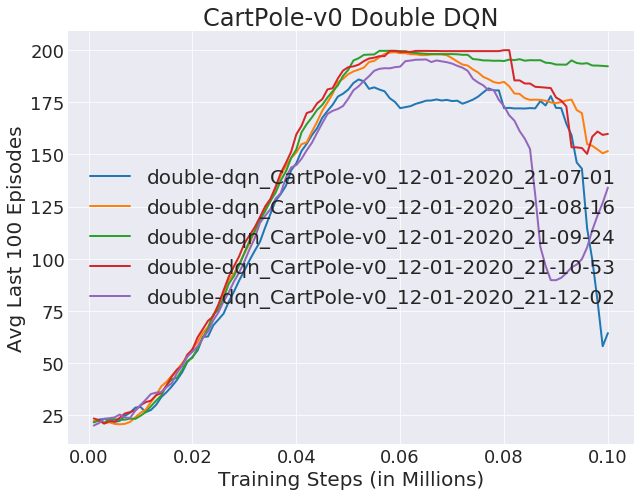

In [8]:
# Again, adjust the list below based on the data you have...

trials = [
    'double-dqn_CartPole-v0_12-01-2020_21-07-01',
    'double-dqn_CartPole-v0_12-01-2020_21-08-16',
    'double-dqn_CartPole-v0_12-01-2020_21-09-24',
    'double-dqn_CartPole-v0_12-01-2020_21-10-53',
    'double-dqn_CartPole-v0_12-01-2020_21-12-02',
]

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
if len(trials) != 5:
    print("WARNING! len(trials) = {}".format(len(trials)))
    print("Please include 5 results for your final report.")
for t in trials:
    assert t[:4] != 'dqn_'
    assert t[:7] == 'double-'
    assert 'CartPole-v0' in t
    assert 'Pong' not in t
plot(logdir='data_dqn', env='CartPole-v0', double_q=True, trials=trials)

# Deliverable 3 of 3: DQN on PongNoFrameskip-v4

On your command line, run:

```
python train_dqn.py PongNoFrameskip-v4 --num_steps 600000
```

For *one* time. Due to computational limitations, we only ask for 600k steps; this should be enough to see some improvement in your results from random performace (which is around -20 to -21). The GPU is the major bottleneck for code speed. Here are some timing benchmarks we have:

- On a two year old Macbook Pro laptop (10.13.6, High Sierra) with no GPU, 600k steps completes in **7.2 hours**.
- On a machine with: NVIDIA Titan X (Pascal) GPU, an i7 7700 CPU with 3.60 GHz and 4 cores, and 64 GB of RAM, 600k steps using the GPU completes in **0.46 hours**.
- If you do the same as the machine above, but with a CPU (that is, the same i7 7700 CPU, etc., but using `tensorflow` instead of `tensorflow-gpu`, so ignoring the GPU), 600k steps completes in about the same time as the Macbook Pro laptop with the CPU, about 7 hours. Thus, a good GPU is essential for pure code speed.

Do not run this until the CartPole results show some improvement in reward. Feel free to run longer if you wish to double check your implementation, but it is not required.

**Adjust the `trials` list below with your data directory name**. Run the following plotting code and save the output for your homework submission.

In [ ]:
# The usual ...
trials = [
    #'dqn_PongNoFrameskip-v4_01-04-2019_21-20-48'
]

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
if len(trials) != 1:
    print("WARNING! len(trials) = {}".format(len(trials)))
    print("Please include 1 result for Pong for your final report.")
for t in trials:
    assert t[:4] == 'dqn_'
    assert t[:7] != 'double-'
    assert 'CartPole-v0' not in t
    assert 'PongNoFrameskip-v4' in t
plot(logdir='data_dqn', env='PongNoFrameskip-v4', double_q=False, trials=trials)

# Anything Else

If you'd like to try out more extensions or other things, feel free to put your comments and results here.